In [1]:
#pip install -U neurodiffeq

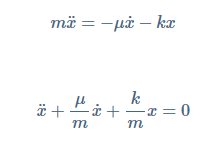

E introducimos las nuevas variables: 
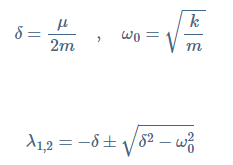

In [2]:
from neurodiffeq.networks import FCNN # fully-connect neural network
import torch.nn as nn
from neurodiffeq.solvers import Solver1D

import numpy as np
import torch
from neurodiffeq.neurodiffeq import safe_diff as diff
from neurodiffeq.ode import solve, solve_system
from neurodiffeq.solvers import Solver1D
from neurodiffeq.monitors import Monitor1D
from neurodiffeq.conditions import IVP
import matplotlib.pyplot as plt
from neurodiffeq.generators import Generator1D
from itertools import chain
from torch.optim import Adam
from torch.optim import SGD
from scipy.integrate import odeint

Ya tratamos el caso sobreamortiguado 

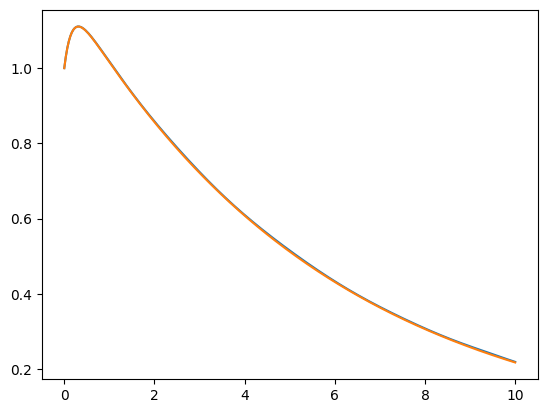

Ahora vamos a analizar el caso subamortiguado, con soluciones analíticas

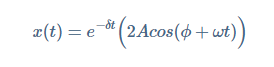

Y con condiciones iniciales:

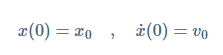

In [3]:
#Params
mu=1
m=1
k=1
delta=mu/(2*m)
w0=np.sqrt(k/m)

x0=1
v0=1

In [4]:
#Sistema de ecuaciones
system = lambda x, t: [diff(x, t, order=2) + 2*delta*diff(x,t,order=1) + w0**2 * x]
init_conditions = [IVP(t_0=0.0, u_0=x0, u_0_prime=v0)]

In [6]:
#Solución analítica con ideint
ti=0
tf=10
t=np.linspace(ti,tf,300)

def sol(t):
  A=-x0/2
  phi=2*np.pi
  return np.exp(-delta*t) * 2*A*np.cos(phi + w0*t)

def pend(x, t, delta, w0):
    theta, omega = x
    dxdt = [omega, -2*delta*omega - w0**2*theta]
    return dxdt

y0 = [x0, v0]
sol = odeint(pend, y0, t, args=(delta, w0))


In [7]:
# specify the training set and validation set
ti=-0.1
tf=10

train_gen = Generator1D(size=100, t_min=ti, t_max=tf, method='uniform')
valid_gen = Generator1D(size=80, t_min=ti, t_max=tf, method='equally-spaced')


In [8]:
# Specify the network architecture
architecture = [FCNN(hidden_units=(15,15,15), actv=nn.Tanh)]

In [9]:
# specify the optimizer
sgd_ho = Adam(
chain.from_iterable(n.parameters() for n in architecture), # this gives all parameters in
lr=0.01 # learning rate
#momentum=0.99, # momentum of SGD
)

D:\Programas\Anaconda2\lib\site-packages\neurodiffeq\monitors.py:44: UserWarning: You seem to be using jupyter notebook with '%matplotlib inline' which can lead to monitor plots not updating. Consider using '%matplotlib notebook' or '%matplotlib widget' instead.
  warnings.warn(


Training Progress:   0%|                                                                      | 0/3000 [00:00<…

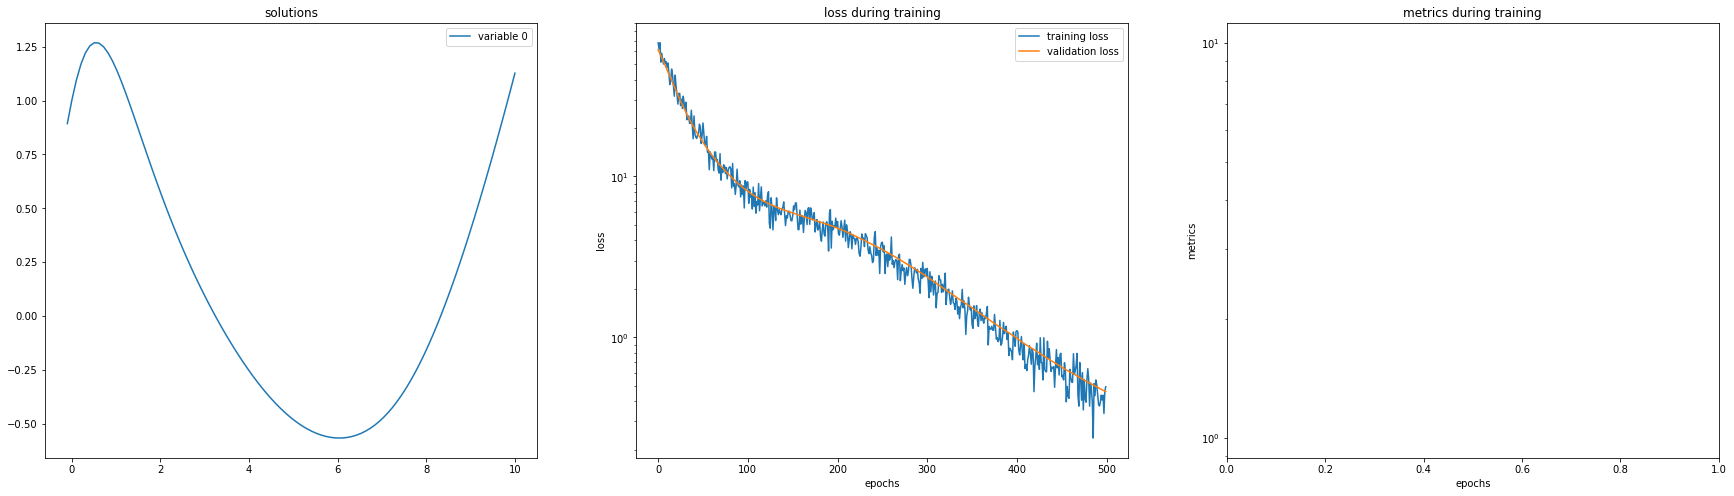

In [10]:
#Solving

#NN params
epochs=3000


# Specify the network architecture
architecture = [FCNN(hidden_units=(40,40), actv=nn.Tanh)]
# Create a monitor callback
monitor_callback = Monitor1D(t_min=ti, t_max=tf, check_every=500).to_callback()
# Create a solver
solver = Solver1D(
ode_system=system,
conditions=init_conditions,
t_min=ti,
t_max=tf,
train_generator=train_gen,
valid_generator=valid_gen,
nets=architecture,
)


#solver= solve(system, condition=init_conditions, t_min=ti, t_max=tf,
#max_epochs=epochs,net=net_ho)
# Fit the solver
solver.fit(max_epochs=epochs, callbacks=[monitor_callback])
# Obtain the solution
solutions = solver.get_solution()

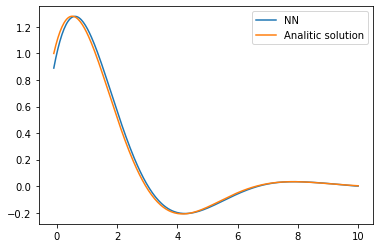

In [13]:
#oscilador=solutions(t,to_numpy=True)
t=np.linspace(ti,tf,300)
oscilador=solutions(t,to_numpy=True)
plt.plot(t,oscilador, label='NN')
plt.plot(t,sol[:,0], label='Analitic solution')
plt.legend()

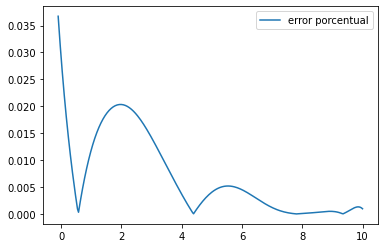

In [14]:
error= abs(oscilador-sol[:,0])/abs(sol[:,0]+2)

plt.plot(t,error, label='error porcentual')
plt.legend()

# Vamos a aumentar las oscilaciones


In [44]:
mu=0.3
m=0.5
k=1
delta=mu/(2*m)
w0=np.sqrt(k/m)

x0=2
v0=0

In [45]:
y0 = [x0, v0]
sol = odeint(pend, y0, t, args=(delta, w0))

In [46]:
system = lambda x, t: [diff(x, t, order=2) + 2*delta*diff(x,t,order=1) + w0**2 * x]
init_conditions = [IVP(t_0=0.0, u_0=x0, u_0_prime=v0)]

In [59]:
# specify the training set and validation set
ti=0
tf=10

train_gen = Generator1D(size=100, t_min=ti, t_max=tf, method='equally-spaced')
valid_gen = Generator1D(size=80, t_min=ti, t_max=tf, method='equally-spaced')


In [60]:
# Specify the network architecture
architecture = [FCNN(hidden_units=(40,40), actv=nn.Tanh)]

In [63]:
# specify the optimizer
sgd_ho = SGD(
chain.from_iterable(n.parameters() for n in architecture), # this gives all parameters in
lr=0.01, # learning rate
momentum=0.9, # momentum of SGD
)


<IPython.core.display.Javascript object>


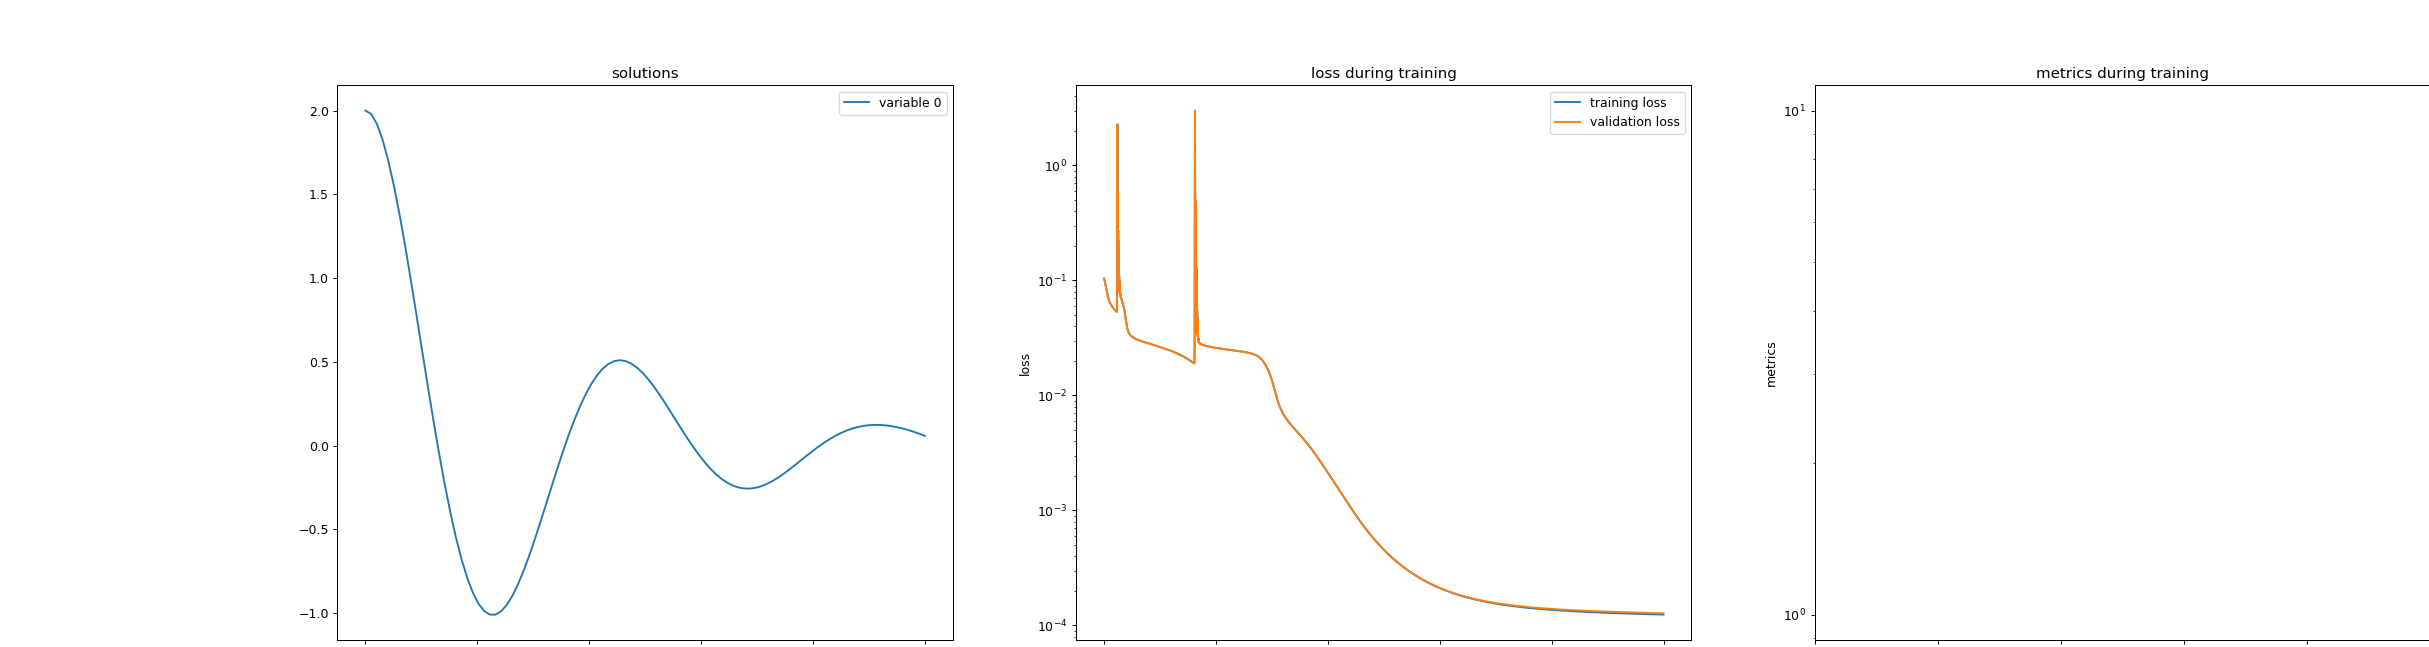

Training Progress:   0%|                                                                     | 0/10000 [00:00<…

In [64]:
#Solving
%matplotlib notebook
init_conditions = [IVP(t_0=0.0, u_0=x0, u_0_prime=v0)]
#NN params
epochs=10000

# Create a monitor callback
monitor_callback = Monitor1D(t_min=ti, t_max=tf, check_every=100).to_callback()
# Create a solver
solver = Solver1D(
ode_system=system,
conditions=init_conditions,
t_min=ti,
t_max=tf,
train_generator=train_gen,
valid_generator=valid_gen,
nets=architecture,
optimizer=sgd_ho
)


#solver= solve(system, condition=init_conditions, t_min=ti, t_max=tf,
#max_epochs=epochs,net=net_ho)
# Fit the solver
solver.fit(max_epochs=epochs, callbacks=[monitor_callback])
# Obtain the solution
solutions = solver.get_solution()

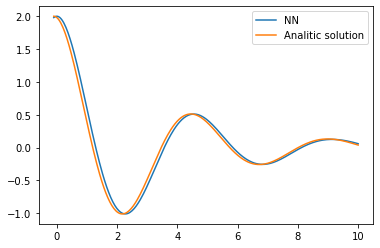

In [65]:
%matplotlib inline
oscilador=solutions(t,to_numpy=True)
plt.plot(t,oscilador, label='NN')
plt.plot(t,sol[:,0], label='Analitic solution')
plt.legend()

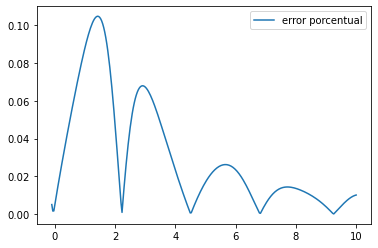

In [68]:
error= abs(oscilador-sol[:,0])/abs(sol[:,0]+2)

plt.plot(t,error, label='error porcentual')
plt.legend()